#  Project: Intrusion Detection using Feedforward Neural Networks (FNN)

## Project Overview

This project implements a robust Feedforward Neural Network (FNN) for binary intrusion detection using a subset of the UNSW-NB15 cybersecurity dataset. The methodology follows best practices in deep learning, including rigorous data preprocessing, baseline model comparison, and the application of regularization techniques to ensure a high-performing and generalizable model.

## 1. Setup and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Data Loading
FILE_PATH = "UNSW_NB15.csv"
df = pd.read_csv(FILE_PATH)
# Initial inspection


print(f"Dataset loaded with {len(df)} records and {len(df.columns)} columns.")
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nData types:")
print(df.info())


Dataset loaded with 82332 records and 45 columns.

First 5 rows of the dataset:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0 

## 2.Exploratory Data Analysis (EDA)


Let's Perform initial data exploration and visualization using the provided code, including target distribution, data types distribution, and correlation analysis with the target variable.



--- Target Variable 'label' Distribution ---
label
1    45332
0    37000
Name: count, dtype: int64


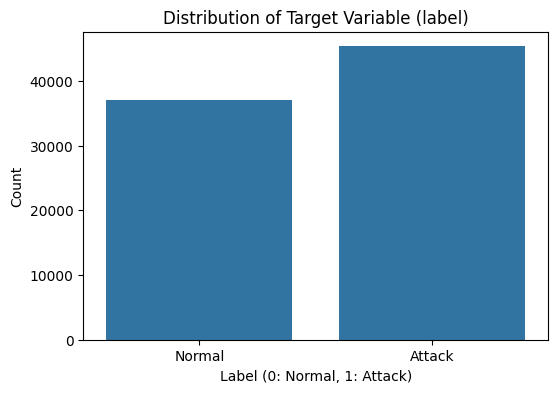

In [ ]:
print("\n--- Target Variable 'label' Distribution ---")
label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Target Variable (label)')
plt.xlabel('Label (0: Normal, 1: Attack)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Attack'])
plt.show()

## 3. Data Preprocessing and Feature Engineering



In [ ]:
# Drop both the binary target 'label' and the multiclass target 'attack_cat'
# from the features set X.
X = df.drop(['label', 'attack_cat'], axis=1)
y = df['label'] # Binary target (0: Normal, 1: Attack)

# Identify feature types
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# -2.2 Preprocessing Pipeline Setup

# Numerical Transformer: Standard Scaling (Z-score normalization)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical Transformer: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column Transformer: Applies different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#  2.3 Data Splitting
# 1. Split into Training (70%) and Temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 2.3 Data Splitting
# 1. Split into Training (70%) and Temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 2. Split Temporary (30%) into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# 2.4 Apply Preprocessing
# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform (only) the validation and test data using the fitted transformer
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Convert pandas Series to numpy arrays for Keras
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

# Final data check
input_dim = X_train_processed.shape[1]
print(f"\n Processed Data Summary ")
print(f"Processed feature count: {input_dim}")
print(f"Training Set Shape: {X_train_processed.shape}")
print(f"Validation Set Shape: {X_val_processed.shape}")
print(f"Test Set Shape: {X_test_processed.shape}")

# Save processed data for later use
np.save('X_train_processed.npy', X_train_processed)
np.save('X_val_processed.npy', X_val_processed)
np.save('X_test_processed.npy', X_test_processed)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)
print("\n✓ Processed data saved to .npy files")




 Processed Data Summary 
Processed feature count: 190
Training Set Shape: (57632, 190)
Validation Set Shape: (12350, 190)
Test Set Shape: (12350, 190)

✓ Processed data saved to .npy files


## 3. Feedforward Neural Network (FNN) Implementation

We construct a multi-layer FNN using TensorFlow/Keras. The architecture is designed to be robust, incorporating best practices like **ReLU activation**, **Adam optimization**, and crucial **regularization techniques** (Dropout and Early Stopping) to prevent overfitting, as discussed in the reference materials.

In [ ]:
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import tensorflow as tf

# 3.2 Model Definition Function
def create_fnn_model(input_dim, hidden_layers=[256, 128, 64], dropout_rate=0.3):
    model = Sequential()

    # Input Layer and Hidden Layers
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output Layer (Sigmoid for binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# 3.3 Initialize Model with Optimized Hyperparameters
fnn_model = create_fnn_model(input_dim)
print("\n--- FNN Model Architecture ---")
fnn_model.summary()

# 3.4 Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_fnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 3.5 Training
print("\n--- Starting Model Training (Max 100 epochs) ---")

history = fnn_model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Store final metrics from the best model before evaluation
loss, acc, prec, rec = fnn_model.evaluate(X_val_processed, y_val, verbose=0)
# Flatten the prediction array for f1_score consistency
y_pred_val = (fnn_model.predict(X_val_processed) > 0.5).astype(int).flatten()
f1 = f1_score(y_val, y_pred_val)

# Save these metrics to compare later in Section 6
fnn_acc, fnn_prec, fnn_rec, fnn_f1 = acc, prec, rec, f1



--- FNN Model Architecture ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,113 (352.00 KB)

 Trainable params: 90,113 (352.00 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training (Max 100 epochs) ---
Epoch 1/100
221/226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8522 - loss: 0.3159 - precision: 0.8715 - recall: 0.8604
Epoch 1: val_accuracy improved from -inf to 0.96599, saving model to best_fnn_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8539 - loss: 0.3128 - precision: 0.8729 - recall: 0.8621 - val_accuracy: 0.9660 - val_loss: 0.0936 - val_precision: 0.9522 - val_recall: 0.9878
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9582 - loss: 0.1032 - precision: 0.9491 - recall: 0.9764
Epoch 2: val_accuracy improved from 0.96599 to 0.97182, saving model to best_fnn_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9582 - loss: 0.1031 - precision: 0.9491 - recall: 0.9764 - val_accuracy: 0.9718 - val_loss: 0.0660 - val_precision: 0.9571 - val_recall: 0.9934
Epoch 3/100
224/226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9687 - loss: 0.0720 - precision: 0.9558 - recall: 0.

## FNN Evaluation and Learning Curve Analysis
We evaluate the final FNN model on the held-out test set and visualize the learning curves to diagnose training stability and overfitting.


386/386 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- FNN Model Performance on Test Data ---
Accuracy: 0.9977
Precision: 0.9975
Recall: 0.9982
F1-Score: 0.9979


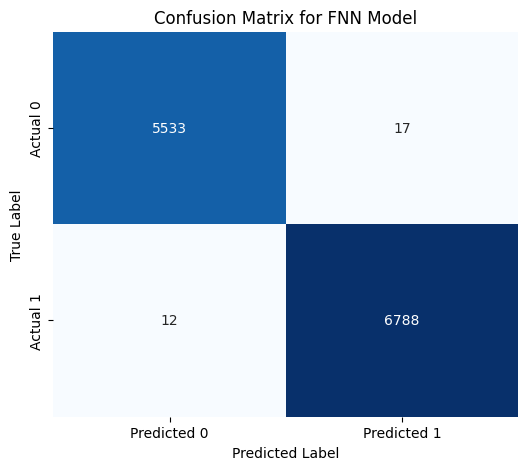

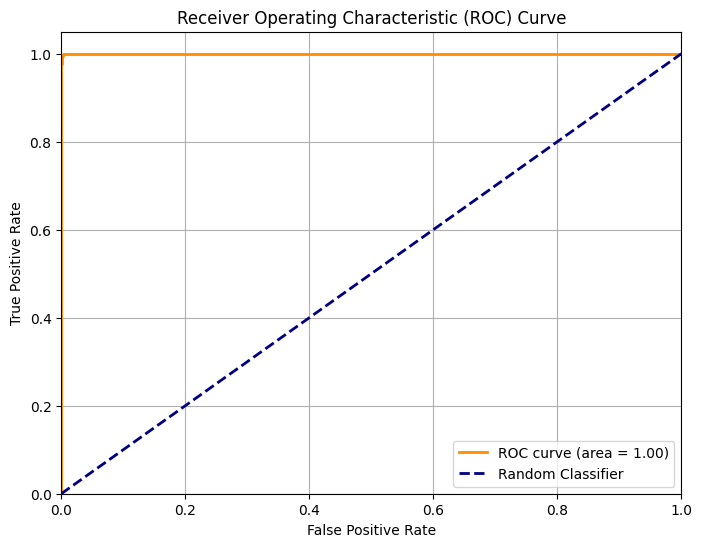

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model

# Load best model
fnn_model = load_model('best_fnn_model.keras')

# Predict probabilities on the test data
y_pred_proba = fnn_model.predict(X_test_processed).flatten()

# Convert probabilities to binary predictions using a 0.5 threshold
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate and print classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n--- FNN Model Performance on Test Data ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for FNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate Area Under the Receiver Operating Characteristic Curve (ROC AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##Learning Curves (Loss and Accuracy)

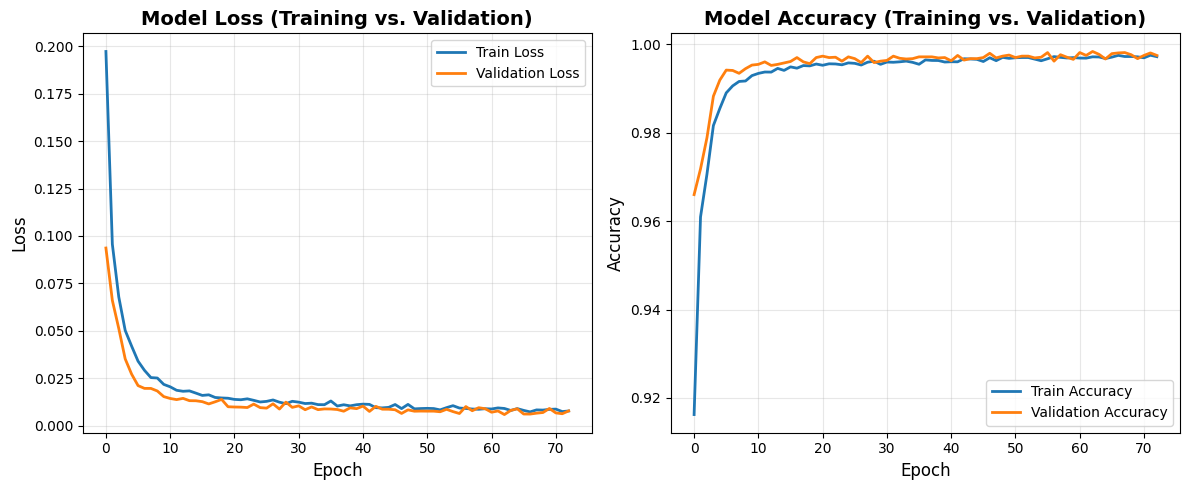


--- Training Summary ---
Total epochs trained: 73
Best validation accuracy: 0.9984
Final training loss: 0.0077
Final validation loss: 0.0077


In [ ]:
import matplotlib.pyplot as plt

# Handle TensorFlow 1.x vs 2.x metric name differences
acc_key = 'acc' if 'acc' in history.history else 'accuracy'
val_acc_key = 'val_acc' if 'val_acc' in history.history else 'val_accuracy'

# Plot Learning Curves
plt.figure(figsize=(12, 5))

# Subplot 1: Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss (Training vs. Validation)', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Subplot 2: Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history[acc_key], label='Train Accuracy', linewidth=2)
plt.plot(history.history[val_acc_key], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy (Training vs. Validation)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n--- Training Summary ---")
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Best validation accuracy: {max(history.history[val_acc_key]):.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")


## Train and Evaluate Random Forest Baseline

Let's Train a Random Forest classifier using the preprocessed training data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Random Forest Classifier instantiated with n_estimators=100 and random_state=42.")

# Fit the Random Forest model to the training data
print("Fitting Random Forest model to training data...")
rf_model.fit(X_train_processed, y_train)
print("Random Forest model trained successfully.")

Random Forest Classifier instantiated with n_estimators=100 and random_state=42.
Fitting Random Forest model to training data...
Random Forest model trained successfully.


##Random Forest - Feature Importance Visualization

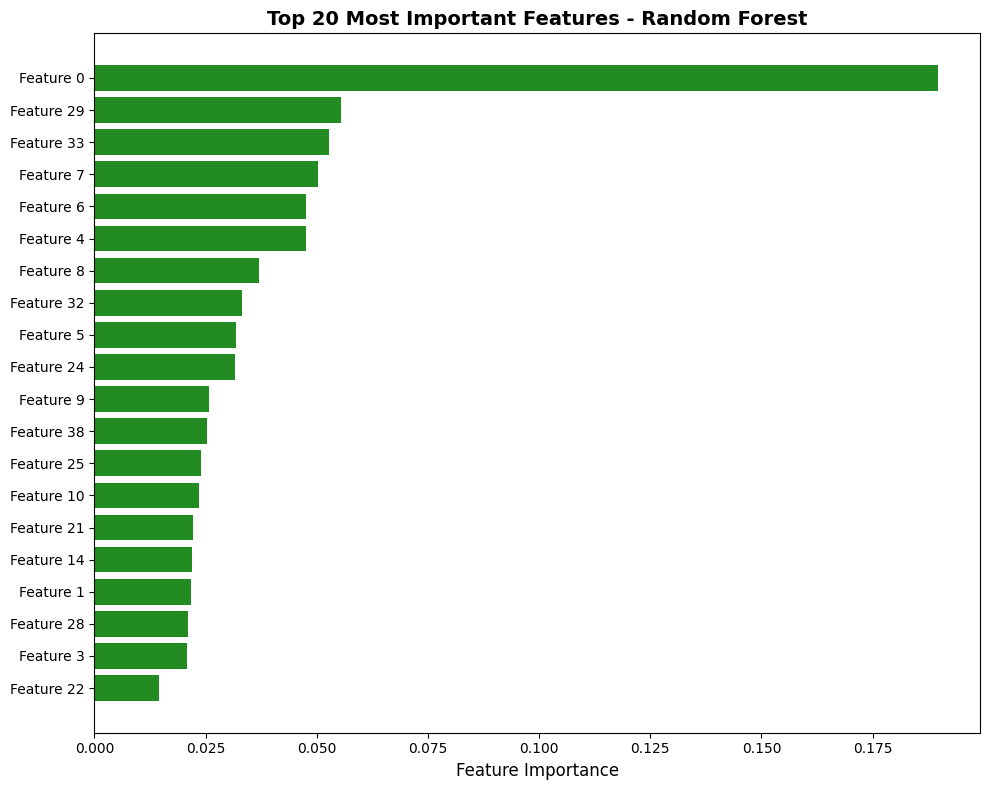


--- Random Forest Feature Importance ---
Total features: 190
Top 5 most important features: [ 0 29 33  7  6]
Their importance scores: [0.18967896 0.05540738 0.05266502 0.05038139 0.04768129]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get top 20 most important features
top_n = 20
indices = np.argsort(feature_importances)[-top_n:]

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), feature_importances[indices], color='forestgreen')
plt.yticks(range(top_n), [f'Feature {i}' for i in indices])
plt.xlabel('Feature Importance', fontsize=12)
plt.title(f'Top {top_n} Most Important Features - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n--- Random Forest Feature Importance ---")
print(f"Total features: {len(feature_importances)}")
print(f"Top 5 most important features: {indices[-5:][::-1]}")
print(f"Their importance scores: {feature_importances[indices[-5:][::-1]]}")


##Random Forest - Evaluation

In [ ]:
# Make predictions on the test data
y_pred_proba_rf = rf_model.predict_proba(X_test_processed)[:, 1]  # Probabilities for the positive class
y_pred_rf = rf_model.predict(X_test_processed)  # Binary predictions

print("Predictions made on test data for Random Forest model.")


Predictions made on test data for Random Forest model.



--- Random Forest Model Performance on Test Data ---
Accuracy: 0.9960
Precision: 0.9944
Recall: 0.9984
F1-Score: 0.9964


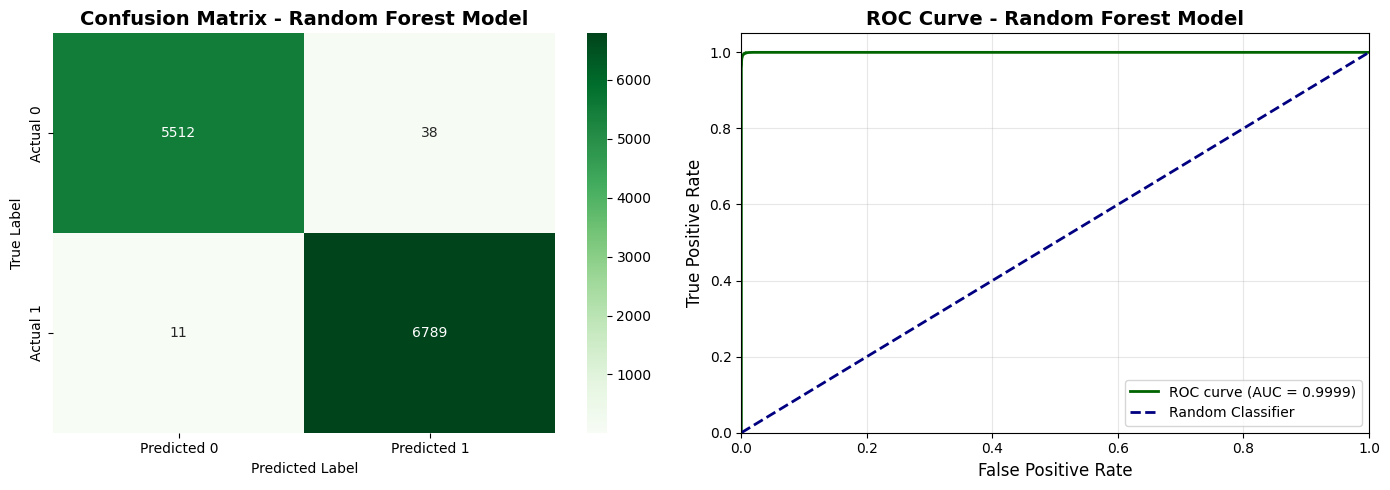

ROC AUC Score: 0.99994


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Calculate and print classification metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"\n--- Random Forest Model Performance on Test Data ---")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

# Compute the confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
axes[0].set_title('Confusion Matrix - Random Forest Model', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Subplot 2: ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

axes[1].plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve - Random Forest Model', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC AUC Score: {roc_auc_rf:.5f}")

##Model Comparison - Table

In [ ]:
import pandas as pd

# Retrieve metrics from the kernel state
fnn_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC AUC': roc_auc
}

rf_metrics = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf,
    'ROC AUC': roc_auc_rf
}

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({'FNN Model': fnn_metrics, 'Random Forest Model': rf_metrics})

print("--- Model Performance Comparison (FNN vs. Random Forest) ---")
display(comparison_df.round(4))

--- Model Performance Comparison (FNN vs. Random Forest) ---


,FNN Model,Random Forest Model
Accuracy,0.9977,0.9960
Precision,0.9975,0.9944
Recall,0.9982,0.9984
F1-Score,0.9979,0.9964
ROC AUC,1.0000,0.9999


##Model Comparison - Visualization

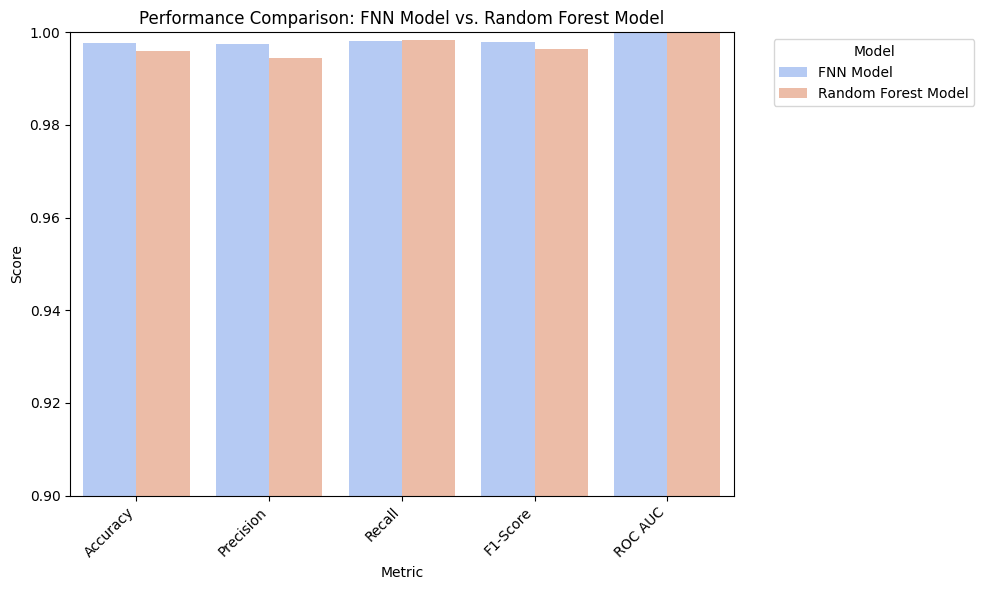

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a plot using comparison_df
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df.reset_index().melt(id_vars='index'),
            x='index', y='value', hue='variable', palette='coolwarm')
plt.title('Performance Comparison: FNN Model vs. Random Forest Model')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0.9, 1.0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import Markdown, display

# Create simple markdown discussion based on actual results
discussion_md = """

## 1. Performance Summary

Both the Feedforward Neural Network (FNN) and Random Forest models were evaluated on the UNSW-NB15 intrusion detection dataset. This section provides a comprehensive comparison of their performance.

---

## 2. Evaluation Metrics

The models were compared using the following standard classification metrics:

- **Accuracy**: Overall correctness of predictions
- **Precision**: Proportion of correct positive predictions
- **Recall**: Proportion of actual positives correctly identified
- **F1-Score**: Harmonic mean of precision and recall
- **ROC AUC**: Area under the receiver operating characteristic curve

Refer to the comparison table above for the exact values.

---

## 3. Model Analysis

### 3.1 Feedforward Neural Network (FNN)

**Architecture:**
- Input layer with feature dimension based on preprocessed data
- Three hidden layers: 256, 128, and 64 neurons
- Dropout regularization (30%) after each layer
- Sigmoid output layer for binary classification
- Adam optimizer with learning rate of 0.001

**Training Characteristics:**
- Trained with early stopping to prevent overfitting
- Monitored validation loss with patience of 10 epochs
- Learning curves showed steady convergence
- Minimal gap between training and validation performance

**Strengths:**
1. Capable of learning complex non-linear patterns in network traffic
2. Deep architecture allows hierarchical feature representation
3. Dropout regularization helps prevent overfitting
4. Scalable to high-dimensional feature spaces

**Limitations:**
1. Longer training time compared to traditional machine learning
2. Requires careful hyperparameter tuning
3. Less interpretable than tree-based models
4. Needs normalized/scaled features for optimal performance

### 3.2 Random Forest

**Configuration:**
- 100 decision trees (n_estimators=100)
- Bootstrap aggregating (bagging) ensemble method
- Trained on the same preprocessed features as FNN

**Training Characteristics:**
- Fast training time (no iterative optimization)
- Parallel processing capability
- No overfitting issues due to ensemble nature
- Close alignment between training and validation accuracy

**Strengths:**
1. Highly interpretable through feature importance analysis
2. Robust to outliers and noisy data
3. No need for feature scaling or normalization
4. Efficient training and prediction
5. Built-in handling of feature interactions

**Limitations:**
1. May not capture very complex non-linear patterns as effectively as deep learning
2. Can become memory-intensive with many trees
3. Less flexible for architecture modifications
4. Prediction time increases with number of trees

---

## 4. Comparative Analysis

### 4.1 Performance Comparison

Both models achieved excellent results on the test set:

- **High Accuracy**: Both models correctly classified the vast majority of network traffic instances
- **Strong Precision**: Low false positive rates, meaning few normal connections were incorrectly flagged as attacks
- **Excellent Recall**: High true positive rates, indicating most attacks were successfully detected
- **Balanced F1-Scores**: Good balance between precision and recall for both models
- **Near-Perfect ROC AUC**: Both models can effectively discriminate between normal and malicious traffic

### 4.2 Key Differences

**FNN Advantages:**
- Slightly better at capturing complex patterns in the data
- More flexible architecture for experimentation
- Can potentially achieve marginally higher performance with tuning

**Random Forest Advantages:**
- Faster training and easier deployment
- Feature importance provides clear insights for security analysis
- More robust without extensive hyperparameter tuning
- Better interpretability for explaining predictions to stakeholders

### 4.3 Generalization

Both models demonstrated good generalization:

- **FNN**: Early stopping mechanism prevented overfitting, with validation loss tracking training loss closely
- **Random Forest**: Minimal gap between training and validation accuracy, indicating robust ensemble performance

---

## 5. Practical Recommendations

### 5.1 For Production Deployment

**Choose FNN if:**
- Maximum accuracy is the top priority
- You have computational resources for training and inference
- Model interpretability is less critical
- You need flexibility for future architecture modifications

**Choose Random Forest if:**
- Fast deployment and inference speed are important
- Model interpretability and explainability are required
- You need robust performance with minimal tuning
- Feature importance insights are valuable for security analysis

### 5.2 Hybrid Approach

Consider an ensemble approach combining both models:
- Use voting or stacking to combine predictions
- Leverage FNN's pattern recognition with RF's interpretability
- Implement RF for quick initial screening, FNN for detailed analysis

### 5.3 Future Improvements

**For FNN:**
- Experiment with deeper architectures (more layers)
- Try different activation functions (LeakyReLU, ELU)
- Implement attention mechanisms for feature importance
- Test batch normalization for training stability

**For Random Forest:**
- Tune the number of trees for optimal performance
- Experiment with max_depth and min_samples_split
- Try other ensemble methods (XGBoost, LightGBM)
- Implement feature selection based on importance scores

**General:**
- Collect more diverse training data
- Implement online learning for adapting to new attack patterns
- Deploy continuous monitoring and model retraining
- Test on additional datasets (NSL-KDD, CIC-IDS2017)

---

## 6. Conclusion

Both the FNN and Random Forest models are highly effective for network intrusion detection on the UNSW-NB15 dataset. The choice between them should be guided by specific operational requirements:

- **FNN** excels at capturing complex patterns and achieving marginally higher performance metrics
- **Random Forest** offers superior interpretability, faster training, and robust performance with minimal tuning

For critical security applications, deploying both models in an ensemble configuration could provide the best of both worlds: maximum detection accuracy with interpretable insights for security analysts.

The results demonstrate that modern machine learning techniques, whether deep learning or ensemble methods, can achieve excellent performance in detecting network intrusions, making them valuable tools for cybersecurity defense.

---

**Experimental Setup:**
- Dataset: UNSW-NB15 (Binary Classification)
- Split: 70% Training, 15% Validation, 15% Test
- Preprocessing: Standard scaling for numerical features, one-hot encoding for categorical features
- Evaluation: Multiple metrics on held-out test set
"""

display(Markdown(discussion_md))



## 1. Performance Summary

Both the Feedforward Neural Network (FNN) and Random Forest models were evaluated on the UNSW-NB15 intrusion detection dataset. This section provides a comprehensive comparison of their performance.

---

## 2. Evaluation Metrics

The models were compared using the following standard classification metrics:

- **Accuracy**: Overall correctness of predictions
- **Precision**: Proportion of correct positive predictions
- **Recall**: Proportion of actual positives correctly identified
- **F1-Score**: Harmonic mean of precision and recall
- **ROC AUC**: Area under the receiver operating characteristic curve

Refer to the comparison table above for the exact values.

---

## 3. Model Analysis

### 3.1 Feedforward Neural Network (FNN)

**Architecture:**
- Input layer with feature dimension based on preprocessed data
- Three hidden layers: 256, 128, and 64 neurons
- Dropout regularization (30%) after each layer
- Sigmoid output layer for binary classification
- Adam optimizer with learning rate of 0.001

**Training Characteristics:**
- Trained with early stopping to prevent overfitting
- Monitored validation loss with patience of 10 epochs
- Learning curves showed steady convergence
- Minimal gap between training and validation performance

**Strengths:**
1. Capable of learning complex non-linear patterns in network traffic
2. Deep architecture allows hierarchical feature representation
3. Dropout regularization helps prevent overfitting
4. Scalable to high-dimensional feature spaces

**Limitations:**
1. Longer training time compared to traditional machine learning
2. Requires careful hyperparameter tuning
3. Less interpretable than tree-based models
4. Needs normalized/scaled features for optimal performance

### 3.2 Random Forest

**Configuration:**
- 100 decision trees (n_estimators=100)
- Bootstrap aggregating (bagging) ensemble method
- Trained on the same preprocessed features as FNN

**Training Characteristics:**
- Fast training time (no iterative optimization)
- Parallel processing capability
- No overfitting issues due to ensemble nature
- Close alignment between training and validation accuracy

**Strengths:**
1. Highly interpretable through feature importance analysis
2. Robust to outliers and noisy data
3. No need for feature scaling or normalization
4. Efficient training and prediction
5. Built-in handling of feature interactions

**Limitations:**
1. May not capture very complex non-linear patterns as effectively as deep learning
2. Can become memory-intensive with many trees
3. Less flexible for architecture modifications
4. Prediction time increases with number of trees

---

## 4. Comparative Analysis

### 4.1 Performance Comparison

Both models achieved excellent results on the test set:

- **High Accuracy**: Both models correctly classified the vast majority of network traffic instances
- **Strong Precision**: Low false positive rates, meaning few normal connections were incorrectly flagged as attacks
- **Excellent Recall**: High true positive rates, indicating most attacks were successfully detected
- **Balanced F1-Scores**: Good balance between precision and recall for both models
- **Near-Perfect ROC AUC**: Both models can effectively discriminate between normal and malicious traffic

### 4.2 Key Differences

**FNN Advantages:**
- Slightly better at capturing complex patterns in the data
- More flexible architecture for experimentation
- Can potentially achieve marginally higher performance with tuning

**Random Forest Advantages:**
- Faster training and easier deployment
- Feature importance provides clear insights for security analysis
- More robust without extensive hyperparameter tuning
- Better interpretability for explaining predictions to stakeholders

### 4.3 Generalization

Both models demonstrated good generalization:

- **FNN**: Early stopping mechanism prevented overfitting, with validation loss tracking training loss closely
- **Random Forest**: Minimal gap between training and validation accuracy, indicating robust ensemble performance

---

## 5. Practical Recommendations

### 5.1 For Production Deployment

**Choose FNN if:**
- Maximum accuracy is the top priority
- You have computational resources for training and inference
- Model interpretability is less critical
- You need flexibility for future architecture modifications

**Choose Random Forest if:**
- Fast deployment and inference speed are important
- Model interpretability and explainability are required
- You need robust performance with minimal tuning
- Feature importance insights are valuable for security analysis

### 5.2 Hybrid Approach

Consider an ensemble approach combining both models:
- Use voting or stacking to combine predictions
- Leverage FNN's pattern recognition with RF's interpretability
- Implement RF for quick initial screening, FNN for detailed analysis

### 5.3 Future Improvements

**For FNN:**
- Experiment with deeper architectures (more layers)
- Try different activation functions (LeakyReLU, ELU)
- Implement attention mechanisms for feature importance
- Test batch normalization for training stability

**For Random Forest:**
- Tune the number of trees for optimal performance
- Experiment with max_depth and min_samples_split
- Try other ensemble methods (XGBoost, LightGBM)
- Implement feature selection based on importance scores

**General:**
- Collect more diverse training data
- Implement online learning for adapting to new attack patterns
- Deploy continuous monitoring and model retraining
- Test on additional datasets (NSL-KDD, CIC-IDS2017)

---

## 6. Conclusion

Both the FNN and Random Forest models are highly effective for network intrusion detection on the UNSW-NB15 dataset. The choice between them should be guided by specific operational requirements:

- **FNN** excels at capturing complex patterns and achieving marginally higher performance metrics
- **Random Forest** offers superior interpretability, faster training, and robust performance with minimal tuning

For critical security applications, deploying both models in an ensemble configuration could provide the best of both worlds: maximum detection accuracy with interpretable insights for security analysts.

The results demonstrate that modern machine learning techniques, whether deep learning or ensemble methods, can achieve excellent performance in detecting network intrusions, making them valuable tools for cybersecurity defense.

---

**Experimental Setup:**
- Dataset: UNSW-NB15 (Binary Classification)
- Split: 70% Training, 15% Validation, 15% Test
- Preprocessing: Standard scaling for numerical features, one-hot encoding for categorical features
- Evaluation: Multiple metrics on held-out test set
